**Por motivos de imagens insuficientes de amigos e familiares, optei pela adaptação do problema da oficina 4. Neste problema irei criar um modelo preditivo onde ele vai observar imagens de pessoas famosas e não famosas e classicá-las de acordo com suas categorias.**

In [30]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

In [31]:
Dataset = '/kaggle/input/pessoas/Pessoas'

Nesta parte do código, categorizo as imagens como "Anônima" ou "Famosa". Uma breve explicação do que ocorre abaixo:

Percorro uma lista com duas categorias (Anonima, Famosa). Na primeira iteração temos que category_path vai ser: /kaggle/input/pessoas/Pessoas/Anonima
Ou seja, o programa vai entrar nesse caminho, fazendo assim, no próximo for, obter o arquivo dentro dessa pasta de "Anonima", logo após o programa vai adicionar este caminho do arquivo em imgs_path e adicionar a label 0 na lista de labels. Pronto, na primeira iteração temos uma imagem que é categorizada como Anonima, o resto ocorre da mesma forma.

In [32]:
img_path = []
labels = [] 

for category in ['Anonima', 'Famosa']:
    category_path = os.path.join(Dataset, category)
    files = os.listdir(category_path)
    for file_name in files:
        file_path = os.path.join(category_path, file_name)
        img_path.append(file_path)
        labels.append(0 if category == 'Anonima' else 1)

Aqui eu percorro as imagens e suas labels para que eu utilize a biblioteca OpenCV para ajustar as imagens de acordo com o que quero (Tamanho, cor...) e faço também uma verificação para saber se a imagem não está corrompida.

In [33]:
valid_imgs = [] 
valid_labels = [] 

for path, label in zip(img_path, labels):
    im = cv2.imread(path)
    if im is None:
        print(f"Imagem corrompida: {path}")
    else:
        im = cv2.resize(im, (64,64))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        valid_imgs.append(im)
        valid_labels.append(label)


images = np.array(valid_imgs)
labels = np.array(valid_labels)

Aqui começamos o nosso planejamento para o treinamento. Após categorizarmos as imagens temos que separar elas em dados de treino e teste e, no caso, nossos X_train e X_test vão ser as imagens, os rótulos vão ser as labels.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

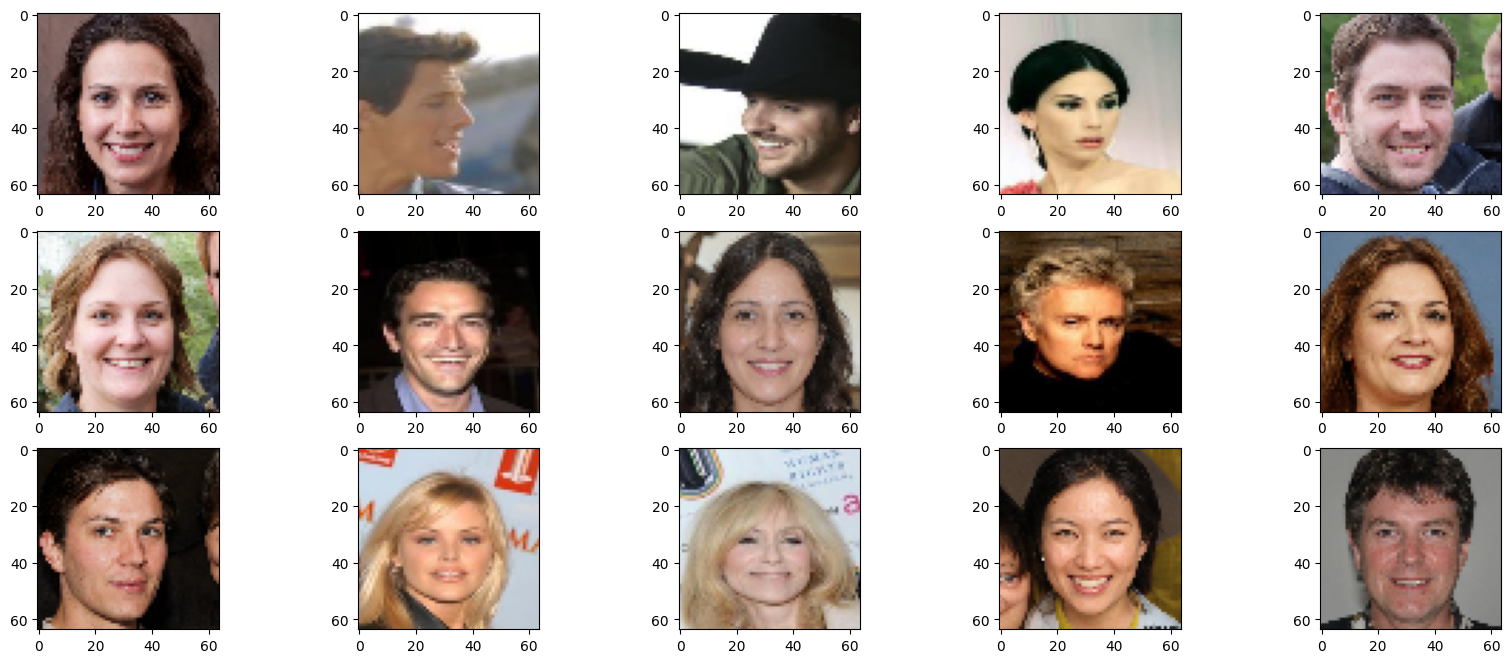

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,5, figsize=(20,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])

O uso de ImageDataGenerator com parâmetros como rotation_range, width_shift_range, e outros, tem como objetivo realizar aumentação de dados (data augmentation). Isso é especialmente útil em tarefas de aprendizado de máquina, pois ajuda a aumentar a variabilidade dos dados e reduz o overfitting.

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

datagen.fit(X_train)

Aqui normalizei as imagens

In [37]:
X_train = X_train/255.0
X_test = X_test/255.0

Nesta parte criei minha rede neural. Optei por uma rede neural com 16 camadas, sendo 4 delas, camadas convolucionais e duas Densas, pois observei que o desempenho do modelo melhora bastante com essa técnica, já que estamos trabalhando com imagens. As camadas de pooling reduzem a resolução da imagem pela metade, mantendo as características principais e as camadas de Conv2D vão aumentando os filtros para aprender características mais complexas. As camadas de Dropout são utilizadas para evitar combater possíveis overfittings

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,486,593 (9.49 MB)

 Trainable params: 2,486,593 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

Aqui temos a compilação do modelo na qual utilizei o otimizador 'Adam' com learning rate de 0.0001, juntamente com a acurácia como métrica.

In [40]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Optei por utilizar a técnica de EarlyStopping, também para evitar overfitting, afinal, se o modelo nao melhora com o passar das épocas não há necessidade de continuar treinando. Defini o parâmetro de patience como 5, isso vai terminar a execução do treinamento se o modelo não melhorar com o passar de 5 épocas.

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                   epochs=50,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.4811 - loss: 0.6972 - val_accuracy: 0.5641 - val_loss: 0.6907
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.4862 - loss: 0.6936 - val_accuracy: 0.4615 - val_loss: 0.6927
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4584 - loss: 0.6898 - val_accuracy: 0.5128 - val_loss: 0.6887
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4171 - loss: 0.7198 - val_accuracy: 0.6410 - val_loss: 0.6918
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5280 - loss: 0.6935 - val_accuracy: 0.6410 - val_loss: 0.6915
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5528 - loss: 0.6803 - val_accuracy: 0.5128 - val_loss: 0.6852
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5143 - loss: 0.6926 - val_accuracy: 0.5641 - val_loss: 0.6919
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5074 - loss: 0.6956 - val_accuracy: 0.

Notamos que a acurácia do modelo foi de 61% para os dados de treinamento e 66% para os dados de teste. O modelo indica algum overfitting mas com algumas alterações é possível melhorá-lo. Além disso, temos os valores de Loss, ou seja, a taxa de erro do meu modelo. Pode-se notar que o modelo tem uma taxa de erro para os dados de treino em 66% e para os dados de teste uma taxa de erro de 68%

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


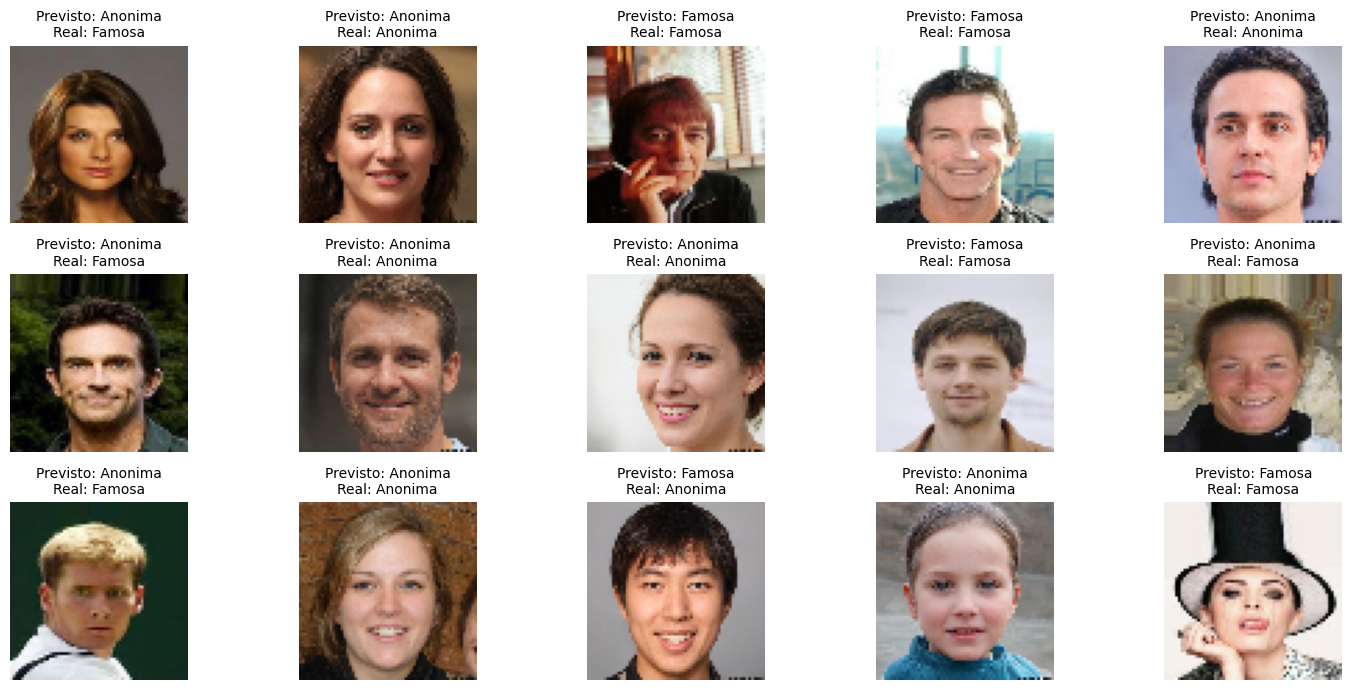

In [47]:
class_names = ['Anonima', 'Famosa']

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test)

# Obter as labels previstas
if predictions.shape[1] == 1:  # Classificação binária
    predicted_labels = (predictions > 0.5).astype(int).flatten()
else:  # Multiclasse
    predicted_labels = np.argmax(predictions, axis=1)

# Exibir as imagens com os nomes das labels previstas e reais
num_images = 15
plt.figure(figsize=(15, 7))

for i in range(num_images):
    plt.subplot(3, 5, i + 1)  # Criar subplots (2 linhas, 5 colunas)
    plt.imshow(X_test[i])  # Mostrar a imagem (verifique se X_test está em formato de imagem)
    plt.title(
        f"Previsto: {class_names[predicted_labels[i]]}\nReal: {class_names[y_test[i]]}",
        fontsize=10
    )
    plt.axis('off')

plt.tight_layout()
plt.show()